**Predicting Respiratory Diseases by the Patient’s Breathing Sounds**

Kaarel Tamuri<br>
Stina-Marie Maripuu

Set within the healthcare industry, this project focuses on supporting the diagnostic process for respiratory diseases. It aims to harness the potential of machine learning to analyze breathing sounds, to help cure patients more effectively and reliably.

We are using CNN (Convolutional Neural Network), which is a network architecture for deep learning that learns directly from data

In [25]:
#LIBARIES
#!pip install pandas numpy librosa matplotlib tqdm resampy imbalanced-learn scikit-learn tensorflow keras

In [2]:
#IMPORTS
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import resampy


from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

from keras.utils import to_categorical




In [3]:
#All PATHS TO DATA
path_files = "archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
path_diagnose = "archive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

In [4]:
#.wav filenames
wav_files = []
for file in os.listdir(path_files):
    if file.endswith(".wav"):
        wav_files.append(file)


#patient_diagnosis.csv
diagnose = pd.read_csv(path_diagnose, header=None)

In [5]:
#Get all file paths
filepaths = []
for i in wav_files:
    path = path_files+i
    filepaths.append(path)


#Find diagnose for every file

file_patient =[]
for i in wav_files:
    pn = int (i[:3])
    file_patient.append(pn)

file_patient = np.array(file_patient)

labels = []
for i in file_patient:
    row = diagnose[diagnose[0] == i]
    labels.append(row[1].values[0])
labels = np.array(labels)

#Remove LTRI and Asthma because there are too few instances
filtered_data = [(fp, pn, label) for fp, pn, label in zip(filepaths, file_patient, labels) if label not in ["LRTI", "Asthma"]]
filepaths, file_patient, labels = zip(*filtered_data)

filepaths = list(filepaths)
file_patient = np.array(file_patient)
labels = np.array(labels)



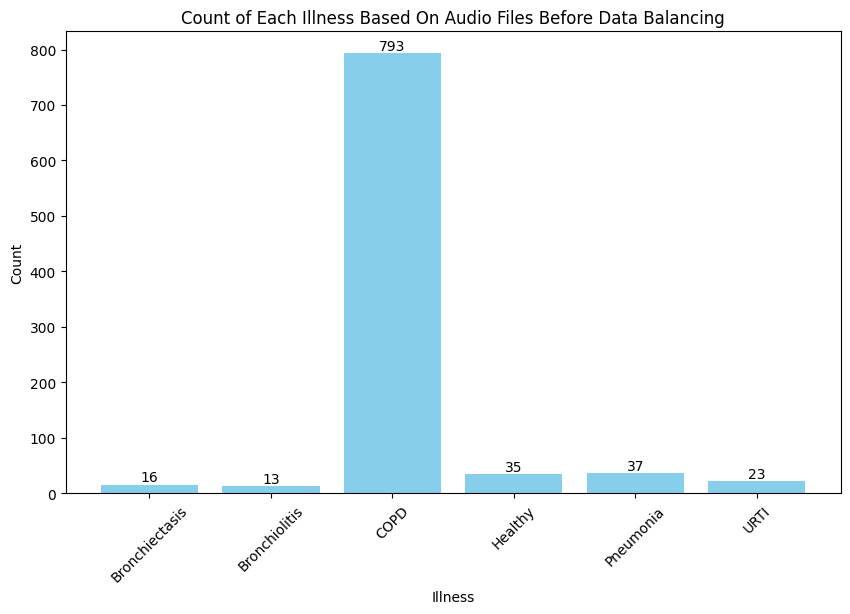

In [6]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(unique_elements, counts_elements, color='skyblue')

# Adding the count labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Illness')
plt.ylabel('Count')
plt.title('Count of Each Illness Based On Audio Files Before Data Balancing')
plt.xticks(rotation=45)
plt.show()

In [7]:
def add_noise(data, noise_level=0.01):
    noise = np.random.randn(len(data))
    return data + noise_level * noise

def time_shift(data, sampling_rate, shift_max=0.2):
    shift_amount = int(sampling_rate * shift_max)
    shift = np.random.randint(-shift_amount, shift_amount)
    return np.roll(data, shift)

def change_pitch(audio, sample_rate, n_steps=2.0, bins_per_octave=12, res_type='soxr_hq', scale=False):
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=n_steps, 
                                       bins_per_octave=bins_per_octave, res_type=res_type, scale=scale)

def change_speed(audio, speed_factor=1.2):
    return librosa.effects.time_stretch(y=audio, rate=speed_factor)



def data_augmentation(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    augmented_audio = [
        add_noise(audio),
        time_shift(audio, sample_rate),
        change_pitch(audio, sample_rate),
        change_speed(audio),
    ]
    return augmented_audio, sample_rate



Maximum: 86.2
Minimum: 7.856
Mean: 21.497306829674798
Median: 20.0
90th Percentile: 20.0


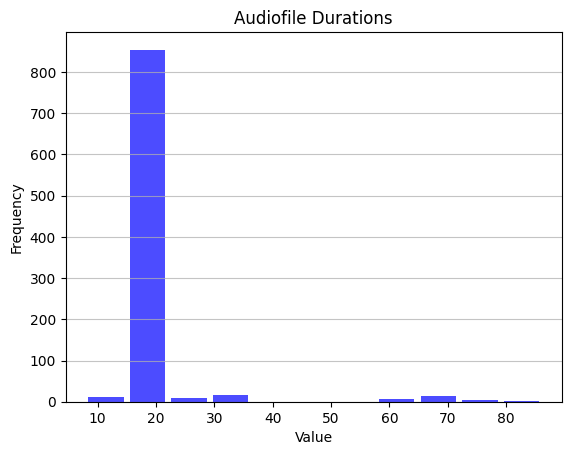

In [8]:
def audioLen(file_path):
    audio, sample_rate = librosa.load(file_path, sr=None)
    duration = len(audio) / sample_rate
    return duration

durations = []
for i in filepaths:
    durations.append(audioLen(i))
    

max_dur = max(durations)
min_dur = min(durations)
mean_dur = np.mean(durations)
median_dur = np.median(durations)
percentile_90 = np.percentile(durations, 90)

# Print the results
print(f"Maximum: {max_dur}")
print(f"Minimum: {min_dur}")
print(f"Mean: {mean_dur}")
print(f"Median: {median_dur}")
print(f"90th Percentile: {percentile_90}")

plt.hist(durations, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
plt.title('Audiofile Durations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Display the histogram
plt.show()

    
    

In [26]:
#I take 90th Percentile to cover as much as possible, but to not be as slow
durLen = 20
paddingLen = int(np.ceil(durLen*22050/512))


def extract(file_path):
    try:
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=durLen) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = paddingLen - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print(file_path, e)
        return None 

    return mfccs
    

In [10]:
X_train, X_test, y_train, y_test = train_test_split(filepaths, labels, test_size=0.2, random_state=5)

In [11]:
augmented_features_train = []
augmented_labels_train = []

# Process and augment training data
for file_path, label in tqdm(zip(X_train, y_train), total=len(X_train), desc="Processing and augmenting training files"):
    # Extract features for original audio
    mfccs = extract(file_path)
    augmented_features_train.append(mfccs)
    augmented_labels_train.append(label)

    # Augment data
    if label not in ["COPD", "LRTI", "Asthma"]:
        augmented_audios, sample_rate = data_augmentation(file_path)
        for aug_audio in augmented_audios:
            mfccs = librosa.feature.mfcc(y=aug_audio, sr=sample_rate, n_mfcc=40)
            pad_width = paddingLen - mfccs.shape[1]
            mfccs_padded = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            augmented_features_train.append(mfccs_padded)
            augmented_labels_train.append(label)

# Convert training data to numpy arrays
features_train = np.array(augmented_features_train)
labels_train = np.array(augmented_labels_train)

# Process test data (no augmentation)
features_test = []
for fp in tqdm(X_test, desc="Processing test files", total=len(X_test)):
    features_test.append(extract(fp))
features_test = np.array(features_test)

labels_test = np.array(y_test)

Processing test files: 100%|█████████████████████████████████████████████████████████| 184/184 [00:44<00:00,  4.14it/s]


In [12]:
# # features per ilness
unique_elements, counts_elements = np.unique(labels_train, return_counts=True)

print("-----Train-----")
for i in range(len(unique_elements)):
    print("Ilness: "+unique_elements[i]+"; Count: "+str(counts_elements[i]))

unique_elements, counts_elements = np.unique(labels_test, return_counts=True)

print("-----Test-----")
for i in range(len(unique_elements)):
    print("Ilness: "+unique_elements[i]+"; Count: "+str(counts_elements[i]))


-----Train-----
Ilness: Bronchiectasis; Count: 70
Ilness: Bronchiolitis; Count: 55
Ilness: COPD; Count: 630
Ilness: Healthy; Count: 140
Ilness: Pneumonia; Count: 150
Ilness: URTI; Count: 100
-----Test-----
Ilness: Bronchiectasis; Count: 2
Ilness: Bronchiolitis; Count: 2
Ilness: COPD; Count: 163
Ilness: Healthy; Count: 7
Ilness: Pneumonia; Count: 7
Ilness: URTI; Count: 3


In [13]:
# Encoding Labels
le = LabelEncoder()
labels_train_encoded = le.fit_transform(labels_train)
labels_train_categorical = to_categorical(labels_train_encoded)

# Reshaping features for CNN input
features_train_reshaped = np.reshape(features_train, (*features_train.shape, 1))

# Apply SMOTE on Training Data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(features_train_reshaped.reshape(features_train_reshaped.shape[0], -1), labels_train_categorical)
X_train_smote = X_train_smote.reshape(X_train_smote.shape[0], features_train.shape[1], features_train.shape[2], 1)

# Process Test Data for Model Evaluation (No Augmentation or SMOTE)
labels_test_encoded = le.transform(labels_test)
labels_test_categorical = to_categorical(labels_test_encoded)
features_test_reshaped = np.reshape(features_test, (*features_test.shape, 1))



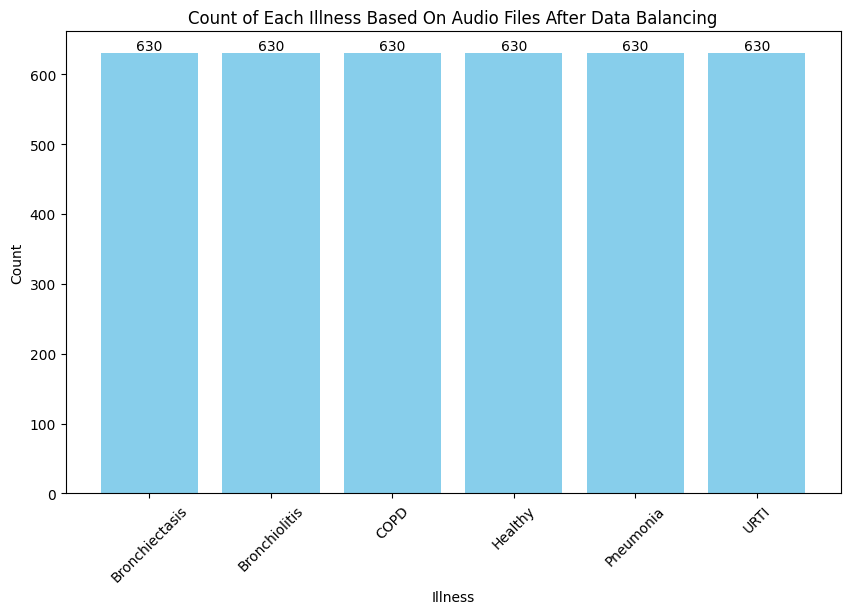

In [14]:
# Convert one-hot encoded labels back to label encoding
y_train_smote_labels = np.argmax(y_train_smote, axis=1)

# Count the occurrences of each class
unique_classes, counts_classes = np.unique(y_train_smote_labels, return_counts=True)

# Map the integer labels back to the original class names
class_names = le.inverse_transform(unique_classes)

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts_classes, color='skyblue')

# Adding count labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.xlabel('Illness')
plt.ylabel('Count')
plt.title('Count of Each Illness Based On Audio Files After Data Balancing')
plt.xticks(rotation=45)
plt.show()


In [15]:
rows = 40 #MFCC number
columns = paddingLen #frames
channels = 1

num_labels = labels_train_categorical.shape[1]
filter_size = 2

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(rows, columns, channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 


In [16]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', metrics.Recall()], optimizer='adam')


In [17]:
# train model
num_epochs = 120
num_batch_size = 128


# Ensure that validation data is the reshaped and encoded test data
model.fit(X_train_smote, y_train_smote, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(features_test_reshaped, labels_test_categorical), verbose=1)


Epoch 1/120


30/30 [==============================] - 19s 555ms/step - loss: 6.3823 - accuracy: 0.2106 - recall: 0.1772 - val_loss: 5.6520 - val_accuracy: 0.0109 - val_recall: 0.0109
Epoch 2/120
30/30 [==============================] - 19s 620ms/step - loss: 1.7749 - accuracy: 0.3156 - recall: 0.1529 - val_loss: 3.7560 - val_accuracy: 0.0543 - val_recall: 0.0109
Epoch 3/120
30/30 [==============================] - 19s 633ms/step - loss: 1.4553 - accuracy: 0.4193 - recall: 0.2185 - val_loss: 2.2743 - val_accuracy: 0.2500 - val_recall: 0.1957
Epoch 4/120
30/30 [==============================] - 19s 626ms/step - loss: 1.3009 - accuracy: 0.4833 - recall: 0.3024 - val_loss: 1.5883 - val_accuracy: 0.4511 - val_recall: 0.3913
Epoch 5/120
30/30 [==============================] - 19s 624ms/step - loss: 1.2038 - accuracy: 0.5214 - recall: 0.3479 - val_loss: 1.2172 - val_accuracy: 0.5652 - val_recall: 0.5489
Epoch 6/120
30/30 [==============================] - 19s 618ms/step - loss: 1.1650 - acc

30/30 [==============================] - 19s 633ms/step - loss: 0.3630 - accuracy: 0.8630 - recall: 0.8272 - val_loss: 0.3071 - val_accuracy: 0.8804 - val_recall: 0.8804
Epoch 44/120
30/30 [==============================] - 19s 650ms/step - loss: 0.3483 - accuracy: 0.8667 - recall: 0.8257 - val_loss: 0.3674 - val_accuracy: 0.8804 - val_recall: 0.8804
Epoch 45/120
30/30 [==============================] - 19s 634ms/step - loss: 0.3530 - accuracy: 0.8701 - recall: 0.8392 - val_loss: 0.4155 - val_accuracy: 0.8587 - val_recall: 0.8587
Epoch 46/120
30/30 [==============================] - 19s 638ms/step - loss: 0.3614 - accuracy: 0.8698 - recall: 0.8378 - val_loss: 0.6052 - val_accuracy: 0.8261 - val_recall: 0.8207
Epoch 47/120
30/30 [==============================] - 19s 633ms/step - loss: 0.3292 - accuracy: 0.8772 - recall: 0.8439 - val_loss: 0.3887 - val_accuracy: 0.8804 - val_recall: 0.8750
Epoch 48/120
30/30 [==============================] - 19s 633ms/step - loss: 0.3168 - accuracy: 0.

Epoch 88/120
30/30 [==============================] - 25s 818ms/step - loss: 0.1475 - accuracy: 0.9468 - recall: 0.9328 - val_loss: 0.4285 - val_accuracy: 0.9185 - val_recall: 0.9185
Epoch 89/120
30/30 [==============================] - 25s 821ms/step - loss: 0.1433 - accuracy: 0.9495 - recall: 0.9381 - val_loss: 0.3657 - val_accuracy: 0.9130 - val_recall: 0.9130
Epoch 90/120
30/30 [==============================] - 25s 824ms/step - loss: 0.1729 - accuracy: 0.9360 - recall: 0.9251 - val_loss: 0.4720 - val_accuracy: 0.9130 - val_recall: 0.9076
Epoch 91/120
30/30 [==============================] - 24s 799ms/step - loss: 0.1749 - accuracy: 0.9360 - recall: 0.9249 - val_loss: 0.4885 - val_accuracy: 0.9076 - val_recall: 0.9076
Epoch 92/120
30/30 [==============================] - 25s 824ms/step - loss: 0.1437 - accuracy: 0.9460 - recall: 0.9347 - val_loss: 0.3797 - val_accuracy: 0.9185 - val_recall: 0.9130
Epoch 93/120
30/30 [==============================] - 25s 820ms/step - loss: 0.1426 -

In [18]:
# Evaluating the model on the training and testing set
train_loss, train_accuracy, train_recall = model.evaluate(X_train_smote, y_train_smote, verbose=1)
test_loss, test_accuracy, test_recall = model.evaluate(features_test_reshaped, labels_test_categorical, verbose=1)

print("Training:")
print("\tAccuracy:", train_accuracy)
print("\tRecall:", train_recall)


print("Testing:")
print("\tAccuracy:", test_accuracy)
print("\tRecall:", test_recall)




6/6 [==============================] - 0s 43ms/step - loss: 0.4778 - accuracy: 0.9185 - recall: 0.9185
Training:
	Accuracy: 0.9227513074874878
	Recall: 0.9140211343765259
Testing:
	Accuracy: 0.91847825050354
	Recall: 0.91847825050354


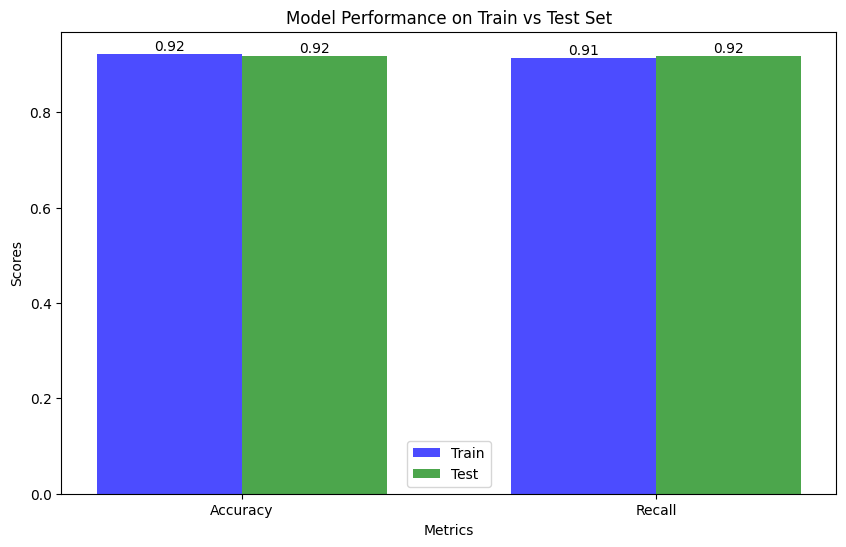

In [19]:
# Data for the bar chart
metrics = ['Accuracy', 'Recall']
train_values = [train_accuracy, train_recall]
test_values = [test_accuracy, test_recall]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

# Creating the bar chart
plt.figure(figsize=(10, 6))
train_bars = plt.bar(x - width/2, train_values, width, label='Train', color='blue', alpha=0.7)
test_bars = plt.bar(x + width/2, test_values, width, label='Test', color='green', alpha=0.7)

# Adding labels to the bars
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

add_labels(train_bars)
add_labels(test_bars)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance on Train vs Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.show()

In [20]:
predictions = model.predict(features_test_reshaped)

predClass = np.argmax(predictions, axis=1)

realClass = np.argmax(labels_test_categorical, axis=1)



6/6 [==============================] - 1s 39ms/step


In [21]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(unique_classes)):
    fpr[i], tpr[i], _ = roc_curve(labels_test_categorical[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [22]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

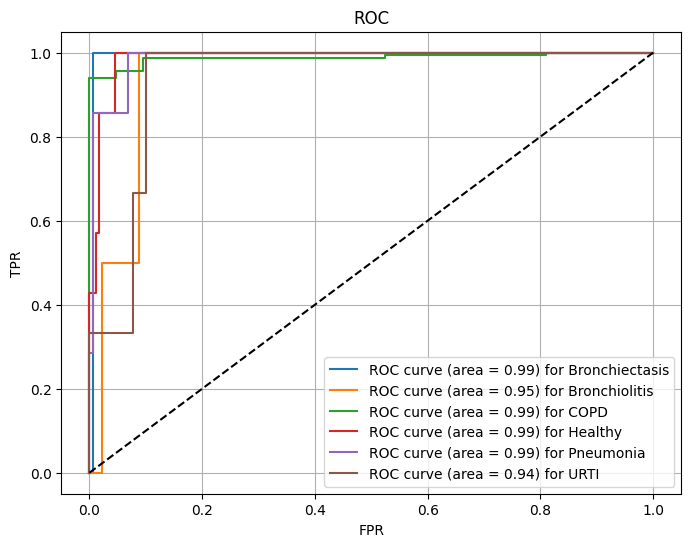

In [23]:
plt.figure(figsize = (8,6))

for i in range(len(c_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {c_names[i]}')
    
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.grid()
plt.show()


In [24]:
print(classification_report(realClass, predClass, target_names=c_names))

                precision    recall  f1-score   support

Bronchiectasis       0.50      1.00      0.67         2
 Bronchiolitis       0.00      0.00      0.00         2
          COPD       0.99      0.96      0.97       163
       Healthy       0.67      0.57      0.62         7
     Pneumonia       0.46      0.86      0.60         7
          URTI       0.25      0.33      0.29         3

      accuracy                           0.92       184
     macro avg       0.48      0.62      0.52       184
  weighted avg       0.93      0.92      0.92       184



C:\Users\tamuri\AppData\Local\anaconda3\envs\IDS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tamuri\AppData\Local\anaconda3\envs\IDS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tamuri\AppData\Local\anaconda3\envs\IDS\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta